# Export Datasets

In [ ]:
from datasets import load_dataset

fst = load_dataset("it5/datasets", "fst", use_auth_token='(<YOUR_TOKEN>)')
hg = load_dataset("it5/datasets", "hg", use_auth_token='(<YOUR_TOKEN>)')
ns = load_dataset("it5/datasets", "ns", use_auth_token='(<YOUR_TOKEN>)')
qa = load_dataset("it5/datasets", "qa", use_auth_token='(<YOUR_TOKEN>)')
qg = load_dataset("it5/datasets", "qg", use_auth_token='(<YOUR_TOKEN>)')
st_g2r = load_dataset("it5/datasets", "st_g2r", use_auth_token='(<YOUR_TOKEN>)')
st_r2g = load_dataset("it5/datasets", "st_r2g", use_auth_token='(<YOUR_TOKEN>)')
wits = load_dataset("it5/datasets", "wits", use_auth_token='(<YOUR_TOKEN>)')

In [13]:
with open("references/informal.txt", 'w') as f:
    for s in fst["test_0"]["informal"]:
        f.write(s.lower() + '\n')

for i in range(4):
    with open(f"references/formal{i}.txt", 'w') as f:
        for s in fst[f"test_{i}"]["formal"]:
            f.write(s.lower() + '\n')

with open(f"references/hg.txt", 'w') as f:
    for s in hg[f"test"]["target"]:
        f.write(s.lower() + '\n')

for name in ["fanpage", "ilpost"]:
    with open(f"references/{name}.txt", 'w') as f:
        for s in ns[f"test_{name}"]["target"]:
            f.write(s.replace("\n", "").lower() + '\n')

with open(f"references/qa.txt", 'w') as f:
    for s in qa[f"test"]["target"]:
        f.write(s.lower() + '\n')

with open(f"references/qg.txt", 'w') as f:
    for s in qg[f"test"]["target"]:
        f.write(s.lower() + '\n')

with open(f"references/st_g2r.txt", 'w') as f:
    for s in st_g2r[f"test"]["headline"]:
        f.write(s.lower() + '\n')

with open(f"references/st_r2g.txt", 'w') as f:
    for s in st_r2g[f"test"]["headline"]:
        f.write(s.lower() + '\n')

with open(f"references/wits.txt", 'w') as f:
    for s in wits[f"test"]["summary"]:
        f.write(s.lower() + '\n')

In [2]:
from datasets import load_metric

rouge = load_metric("rouge")
bertscore = load_metric("bertscore")

rouge_kwargs = {
    'rouge_types': ["rouge1", "rouge2", "rougeL"],
    'use_agregator': False,
    'use_stemmer': False,
}
bertscore_kwargs = {
    "model_type": "dbmdz/bert-base-italian-xxl-uncased",
    "lang": "it",
    "num_layers": 10,
    "batch_size": 16,
    "rescale_with_baseline": True,
    "baseline_path": "configs/bertscore_baseline_ita.tsv",
    "use_fast_tokenizer": True
}

2022-02-18 14:54:29.237870: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-18 14:54:29.237892: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
def compute_i2f(model, metric, kwargs):
    with open("references/formal0.txt", 'r') as f:
        ref0 = [s.strip() for s in f.readlines()]
    with open("references/formal1.txt", 'r') as f:
        ref1 = [s.strip() for s in f.readlines()]
    with open("references/formal2.txt", 'r') as f:
        ref2 = [s.strip() for s in f.readlines()]
    with open("references/formal3.txt", 'r') as f:
        ref3 = [s.strip() for s in f.readlines()]
    with open(f"model_predictions/{model}-informal-to-formal{'-ita' if 'mt5' in model else ''}_test_0.txt", 'r') as f:
        hyp = [s.strip() for s in f.readlines()]
    scores0 = {k:[s.fmeasure for s in v] for k, v in metric.compute(predictions=hyp, references=ref0, **kwargs).items()}
    scores1 = {k:[s.fmeasure for s in v] for k, v in metric.compute(predictions=hyp, references=ref1, **kwargs).items()}
    scores2 = {k:[s.fmeasure for s in v] for k, v in metric.compute(predictions=hyp, references=ref2, **kwargs).items()}
    scores3 = {k:[s.fmeasure for s in v] for k, v in metric.compute(predictions=hyp, references=ref3, **kwargs).items()}
    return {
        s:sum([max(x0, x1, x2, x3) for x0, x1, x2, x3 in zip(scores0[s], scores1[s], scores2[s], scores3[s])])/len(scores0[s])
        for s in scores0.keys()
    }

print("fst_i2f")
print("mt5-small", compute_i2f("mt5-small", rouge, rouge_kwargs))
print("mt5-base", compute_i2f("mt5-base", rouge, rouge_kwargs))
print("it5-small", compute_i2f("it5-small", rouge, rouge_kwargs))
print("it5-base", compute_i2f("it5-base", rouge, rouge_kwargs))
print("it5-large", compute_i2f("it5-large", rouge, rouge_kwargs))


fst_i2f
mt5-small {'rouge1': 0.6380633185849459, 'rouge2': 0.4458092701802957, 'rougeL': 0.6202414964282672}
mt5-base {'rouge1': 0.6618245718094221, 'rouge2': 0.4710014012177415, 'rougeL': 0.6419942941682181}
it5-small {'rouge1': 0.6468545736780796, 'rouge2': 0.4514449451743173, 'rougeL': 0.6280476143942586}
it5-base {'rouge1': 0.5826060015283062, 'rouge2': 0.40296946773710746, 'rougeL': 0.561013620053419}
it5-large {'rouge1': 0.6627748711489103, 'rouge2': 0.47466091339493427, 'rougeL': 0.6446160596543035}


In [ ]:
def compute_f2i(model, metric, kwargs):
    with open("references/informal.txt", 'r') as f:
        ref = [s.strip() for s in f.readlines()]
    with open(f"model_predictions/{model}-formal-to-informal{'-ita' if 'mt5' in model else ''}_test_0.txt", 'r') as f:
        hyp0 = [s.strip() for s in f.readlines()]
    with open(f"model_predictions/{model}-formal-to-informal{'-ita' if 'mt5' in model else ''}_test_1.txt", 'r') as f:
        hyp1 = [s.strip() for s in f.readlines()]
    with open(f"model_predictions/{model}-formal-to-informal{'-ita' if 'mt5' in model else ''}_test_2.txt", 'r') as f:
        hyp2 = [s.strip() for s in f.readlines()]
    with open(f"model_predictions/{model}-formal-to-informal{'-ita' if 'mt5' in model else ''}_test_3.txt", 'r') as f:
        hyp3 = [s.strip() for s in f.readlines()]
    scores0 = {k:[s.fmeasure for s in v] for k, v in metric.compute(predictions=hyp0, references=ref, **kwargs).items()}
    scores1 = {k:[s.fmeasure for s in v] for k, v in metric.compute(predictions=hyp1, references=ref, **kwargs).items()}
    scores2 = {k:[s.fmeasure for s in v] for k, v in metric.compute(predictions=hyp2, references=ref, **kwargs).items()}
    scores3 = {k:[s.fmeasure for s in v] for k, v in metric.compute(predictions=hyp3, references=ref, **kwargs).items()}
    return {
        s:sum([max(x0, x1, x2, x3) for x0, x1, x2, x3 in zip(scores0[s], scores1[s], scores2[s], scores3[s])])/len(scores0[s])
        for s in scores0.keys()
    }

print("fst_f2i")
print("mt5-small", compute_f2i("mt5-small", rouge, rouge_kwargs))
print("mt5-base", compute_f2i("mt5-base", rouge, rouge_kwargs))
print("it5-small", compute_f2i("it5-small", rouge, rouge_kwargs))
print("it5-base", compute_f2i("it5-base", rouge, rouge_kwargs))
print("it5-large", compute_f2i("it5-large", rouge, rouge_kwargs))

```shell
fst_f2i
mt5-small {'rouge1': 0.6507888177602231, 'rouge2': 0.44986764030237103, 'rougeL': 0.6312564448356363}
mt5-base {'rouge1': 0.6526409092033428, 'rouge2': 0.44919264158684963, 'rougeL': 0.6316971160855954}
it5-small {'rouge1': 0.6496212216212729, 'rouge2': 0.4495710077185604, 'rougeL': 0.6314902152941851}
it5-base {'rouge1': 0.6520272511796381, 'rouge2': 0.44582644850047853, 'rougeL': 0.6315355975325985}
it5-large {'rouge1': 0.6107063934564821, 'rouge2': 0.40917491561108527, 'rougeL': 0.5864980585629622}
```

In [ ]:
rouge_kwargs = {
    'rouge_types': ["rouge1", "rouge2", "rougeL"],
}

def compute_rouge(ref_file, hyp_file, kwargs):
    with open(f"references/{ref_file}.txt", 'r') as f:
        ref = [s.strip() for s in f.readlines()]
    with open(f"model_predictions/{hyp_file}.txt", 'r') as f:
        hyp = [s.strip() for s in f.readlines()]
    return {k:v.mid.fmeasure for k,v in rouge.compute(predictions=hyp, references=ref, **kwargs).items()}

print("hg")
print("mt5-small", compute_rouge("hg", "mt5-small-headline-generation-ita_test", rouge_kwargs))
print("mt5-base", compute_rouge("hg", "mt5-base-headline-generation-ita_test", rouge_kwargs))
print("it5-base", compute_rouge("hg", "it5-base-headline-generation_test", rouge_kwargs))
print("it5-small", compute_rouge("hg", "it5-small-headline-generation_test", rouge_kwargs))
print("it5-large", compute_rouge("hg", "it5-large-headline-generation_test", rouge_kwargs))

print("qg")
print("mt5-small", compute_rouge("qg", "mt5-small-question-generation-ita_test", rouge_kwargs))
print("mt5-base", compute_rouge("qg", "mt5-base-question-generation-ita_test", rouge_kwargs))
print("it5-base", compute_rouge("qg", "it5-base-question-generation_test", rouge_kwargs))
print("it5-small", compute_rouge("qg", "it5-small-question-generation_test", rouge_kwargs))
print("it5-large", compute_rouge("qg", "it5-large-question-generation_test", rouge_kwargs))

print("ns_ilpost")
print("mt5-small", compute_rouge("ilpost", "mt5-small-news-summarization-ita_test_ilpost", rouge_kwargs))
print("mt5-base", compute_rouge("ilpost", "mt5-base-news-summarization-ita_test_ilpost", rouge_kwargs))
print("it5-base", compute_rouge("ilpost", "it5-base-news-summarization_test_ilpost", rouge_kwargs))
print("it5-small", compute_rouge("ilpost", "it5-small-news-summarization_test_ilpost", rouge_kwargs))
print("it5-large", compute_rouge("ilpost", "it5-large-news-summarization_test_ilpost", rouge_kwargs))

print("ns_fanpage")
print("mt5-small", compute_rouge("fanpage", "mt5-small-news-summarization-ita_test_fanpage", rouge_kwargs))
print("mt5-base", compute_rouge("fanpage", "mt5-base-news-summarization-ita_test_fanpage", rouge_kwargs))
print("it5-base", compute_rouge("fanpage", "it5-base-news-summarization_test_fanpage", rouge_kwargs))
print("it5-small", compute_rouge("fanpage", "it5-small-news-summarization_test_fanpage", rouge_kwargs))
print("it5-large", compute_rouge("fanpage", "it5-large-news-summarization_test_fanpage", rouge_kwargs))

print("wits")
print("mt5-small", compute_rouge("wits", "mt5-small-wiki-summarization-ita_test", rouge_kwargs))
print("mt5-base", compute_rouge("wits", "mt5-base-wiki-summarization-ita_test", rouge_kwargs))
print("it5-base", compute_rouge("wits", "it5-base-wiki-summarization_test", rouge_kwargs))
print("it5-small", compute_rouge("wits", "it5-small-wiki-summarization_test", rouge_kwargs))
print("it5-large", compute_rouge("wits", "it5-large-wiki-summarization_test", rouge_kwargs))

print("st_g2r")
print("mt5-small", compute_rouge("st_g2r", "mt5-small-ilgiornale-to-repubblica-ita_test", rouge_kwargs))
print("mt5-base", compute_rouge("st_g2r", "mt5-base-ilgiornale-to-repubblica-ita_test", rouge_kwargs))
print("it5-base", compute_rouge("st_g2r", "it5-base-ilgiornale-to-repubblica_test", rouge_kwargs))
print("it5-small", compute_rouge("st_g2r", "it5-small-ilgiornale-to-repubblica_test", rouge_kwargs))
print("it5-large", compute_rouge("st_g2r", "it5-large-ilgiornale-to-repubblica_test", rouge_kwargs))

print("st_r2g")
print("mt5-small", compute_rouge("st_r2g", "mt5-small-repubblica-to-ilgiornale-ita_test", rouge_kwargs))
print("mt5-base", compute_rouge("st_r2g", "mt5-base-repubblica-to-ilgiornale-ita_test", rouge_kwargs))
print("it5-base", compute_rouge("st_r2g", "it5-base-repubblica-to-ilgiornale_test", rouge_kwargs))
print("it5-small", compute_rouge("st_r2g", "it5-small-repubblica-to-ilgiornale_test", rouge_kwargs))
print("it5-large", compute_rouge("st_r2g", "it5-large-repubblica-to-ilgiornale_test", rouge_kwargs))

# Bertscore

The following results were obtaining by running the following code on Google Colab:

### i2f

- mt5-small 0.6840756445527076

- mt5-base 0.7121593571454287

- it5-small 0.7023371724784374

- it5-base 0.6409667591750622

- it5-large 0.7144228211343289

### f2i

- mt5-small 0.6656641669273377

- mt5-base 0.667281984001398

- it5-small 0.6633332076966763

- it5-base 0.6654541707187891

- it5-large 0.6129066628664732

### hg

- mt5-small 0.4082620157602709

- mt5-base 0.427382238739694

- it5-base 0.4326194681830937

- it5-small 0.413982511658594

- it5-large 0.4299530544915586

### qg

- mt5-small 0.4625033930285283

- mt5-base 0.49497215210106765

- it5-base 0.5157709655244594

- it5-small 0.5052396924401265

- it5-large 0.5221246630159012

### ns_ilpost

- mt5-small 0.3797239664886993

- mt5-base 0.3990554356227883

- it5-base 0.06487068192530966

- it5-small 0.3949358254239302

- it5-large 0.31312756502520644

### ns_fanpage

- mt5-small 0.36950530688046235

- mt5-base 0.3867714759344327

- it5-base 0.024452764880952244

- it5-small 0.3773716842996095

- it5-large 0.3163143912487514

### wits

- mt5-small 0.5171176899618644

- mt5-base 0.5195369849113791

- it5-base 0.5302166683937306

- it5-small 0.5037536359048216

- it5-large 0.5078669870631595

### st_g2r

- mt5-small 0.3818697871814689

- mt5-base 0.41139199032320173

- it5-base 0.42534179535519795

- it5-small 0.4044020188880153

- it5-large 0.40020734380937645

### st_r2g

- mt5-small 0.3629064853049815

- mt5-base 0.38393800050299615

- it5-base 0.3962114055787213

- it5-small 0.3801775599762797

In [ ]:
def compute_i2f(model, metric, kwargs):
    with open("refs/formal0.txt", 'r') as f:
        ref0 = [s.strip() for s in f.readlines()]
    with open("references/formal1.txt", 'r') as f:
        ref1 = [s.strip() for s in f.readlines()]
    with open("references/formal2.txt", 'r') as f:
        ref2 = [s.strip() for s in f.readlines()]
    with open("references/formal3.txt", 'r') as f:
        ref3 = [s.strip() for s in f.readlines()]
    with open(f"model_predictions/{model}-informal-to-formal{'-ita' if 'mt5' in model else ''}_test_0.txt", 'r') as f:
        hyp = [s.strip() for s in f.readlines()]
    
    scores0 = metric.compute(predictions=hyp, references=ref0, **kwargs)["f1"]
    scores1 = metric.compute(predictions=hyp, references=ref1, **kwargs)["f1"]
    scores2 = metric.compute(predictions=hyp, references=ref2, **kwargs)["f1"]
    scores3 = metric.compute(predictions=hyp, references=ref3, **kwargs)["f1"]
    return sum([max(x0, x1, x2, x3) for x0, x1, x2, x3 in zip(scores0, scores1, scores2, scores3)])/len(scores0)

print("bertscore i2f")
print("mt5-small", compute_i2f("mt5-small", bertscore, bertscore_kwargs))
print("mt5-base", compute_i2f("mt5-base", bertscore, bertscore_kwargs))
print("it5-small", compute_i2f("it5-small", bertscore, bertscore_kwargs))
print("it5-base", compute_i2f("it5-base", bertscore, bertscore_kwargs))
print("it5-large", compute_i2f("it5-large", bertscore, bertscore_kwargs))

In [ ]:
def compute_f2i(model, metric, kwargs):
    with open("references/informal.txt", 'r') as f:
        ref = [s.strip() for s in f.readlines()]
    with open(f"model_predictions/{model}-formal-to-informal{'-ita' if 'mt5' in model else ''}_test_0.txt", 'r') as f:
        hyp0 = [s.strip() for s in f.readlines()]
    with open(f"model_predictions/{model}-formal-to-informal{'-ita' if 'mt5' in model else ''}_test_1.txt", 'r') as f:
        hyp1 = [s.strip() for s in f.readlines()]
    with open(f"model_predictions/{model}-formal-to-informal{'-ita' if 'mt5' in model else ''}_test_2.txt", 'r') as f:
        hyp2 = [s.strip() for s in f.readlines()]
    with open(f"model_predictions/{model}-formal-to-informal{'-ita' if 'mt5' in model else ''}_test_3.txt", 'r') as f:
        hyp3 = [s.strip() for s in f.readlines()]
    scores0 = metric.compute(predictions=hyp0, references=ref, **kwargs)["f1"]
    scores1 = metric.compute(predictions=hyp1, references=ref, **kwargs)["f1"]
    scores2 = metric.compute(predictions=hyp2, references=ref, **kwargs)["f1"]
    scores3 = metric.compute(predictions=hyp3, references=ref, **kwargs)["f1"]
    return sum([max(x0, x1, x2, x3) for x0, x1, x2, x3 in zip(scores0, scores1, scores2, scores3)])/len(scores0)

print("bertscore f2i")
print("mt5-small", compute_f2i("mt5-small", bertscore, bertscore_kwargs))
print("mt5-base", compute_f2i("mt5-base", bertscore, bertscore_kwargs))
print("it5-small", compute_f2i("it5-small", bertscore, bertscore_kwargs))
print("it5-base", compute_f2i("it5-base", bertscore, bertscore_kwargs))
print("it5-large", compute_f2i("it5-large", bertscore, bertscore_kwargs))

In [ ]:
def compute_bertscore(ref_file, hyp_file, kwargs):
    with open(f"references/{ref_file}.txt", 'r') as f:
        ref = [s.strip() for s in f.readlines()]
    with open(f"model_predictions/{hyp_file}.txt", 'r') as f:
        hyp = [s.strip() for s in f.readlines()]
    scores = bertscore.compute(predictions=hyp, references=ref, **kwargs)["f1"]
    return sum(scores) / len(scores)

In [ ]:
print("hg")
print("mt5-small", compute_bertscore("hg", "mt5-small-headline-generation-ita_test", bertscore_kwargs))
print("mt5-base", compute_bertscore("hg", "mt5-base-headline-generation-ita_test", bertscore_kwargs))
print("it5-base", compute_bertscore("hg", "it5-base-headline-generation_test", bertscore_kwargs))
print("it5-small", compute_bertscore("hg", "it5-small-headline-generation_test", bertscore_kwargs))
print("it5-large", compute_bertscore("hg", "it5-large-headline-generation_test", bertscore_kwargs))

print("qg")
print("mt5-small", compute_bertscore("qg", "mt5-small-question-generation-ita_test", bertscore_kwargs))
print("mt5-base", compute_bertscore("qg", "mt5-base-question-generation-ita_test", bertscore_kwargs))
print("it5-base", compute_bertscore("qg", "it5-base-question-generation_test", bertscore_kwargs))
print("it5-small", compute_bertscore("qg", "it5-small-question-generation_test", bertscore_kwargs))
print("it5-large", compute_bertscore("qg", "it5-large-question-generation_test", bertscore_kwargs))

print("ns_ilpost")
print("mt5-small", compute_bertscore("ilpost", "mt5-small-news-summarization-ita_test_ilpost", bertscore_kwargs))
print("mt5-base", compute_bertscore("ilpost", "mt5-base-news-summarization-ita_test_ilpost", bertscore_kwargs))
print("it5-base", compute_bertscore("ilpost", "it5-base-news-summarization_test_ilpost", bertscore_kwargs))
print("it5-small", compute_bertscore("ilpost", "it5-small-news-summarization_test_ilpost", bertscore_kwargs))
print("it5-large", compute_bertscore("ilpost", "it5-large-news-summarization_test_ilpost", bertscore_kwargs))

print("ns_fanpage")
print("mt5-small", compute_bertscore("fanpage", "mt5-small-news-summarization-ita_test_fanpage", bertscore_kwargs))
print("mt5-base", compute_bertscore("fanpage", "mt5-base-news-summarization-ita_test_fanpage", bertscore_kwargs))
print("it5-base", compute_bertscore("fanpage", "it5-base-news-summarization_test_fanpage", bertscore_kwargs))
print("it5-small", compute_bertscore("fanpage", "it5-small-news-summarization_test_fanpage", bertscore_kwargs))
print("it5-large", compute_bertscore("fanpage", "it5-large-news-summarization_test_fanpage", bertscore_kwargs))

print("wits")
print("mt5-small", compute_bertscore("wits", "mt5-small-wiki-summarization-ita_test", bertscore_kwargs))
print("mt5-base", compute_bertscore("wits", "mt5-base-wiki-summarization-ita_test", bertscore_kwargs))
print("it5-base", compute_bertscore("wits", "it5-base-wiki-summarization_test", bertscore_kwargs))
print("it5-small", compute_bertscore("wits", "it5-small-wiki-summarization_test", bertscore_kwargs))
print("it5-large", compute_bertscore("wits", "it5-large-wiki-summarization_test", bertscore_kwargs))

# CHANGE-it Classifiers Eval

In [ ]:
!pip install transformers==3.0.2

In [ ]:
!wget -O h-a-classifier.h5 https://unipiit-my.sharepoint.com/:u:/g/personal/l_demattei_studenti_unipi_it/Ee6SwfKkLzFJk-_1ho3LXFUB0fZlADKGdod42qM0dmvGZA?download=1
!wget -O h-h-classifier.h5 https://unipiit-my.sharepoint.com/:u:/g/personal/l_demattei_studenti_unipi_it/EZhDwNJSfz1No5WT9t5hOjMB7zrXdJBBu2dGEZCxElIhqA?download=1

In [ ]:
import pandas as pd
import numpy as np
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer

# Defining some key variables that will be used later on in the training
HH_MAX_LEN = 64
HH_VALID_BATCH_SIZE = 128
HA_MAX_LEN = 512
HA_VALID_BATCH_SIZE = 8
HH_MODEL_PATH = "/content/h-h-classifier.h5"
HA_MODEL_PATH = "/content/h-a-classifier.h5"
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = AutoModel.from_pretrained('bert-base-multilingual-cased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 1)
    
    def forward(self, ids, mask):
        output_1= self.l1(ids, mask)
        output_2 = self.l2(output_1[0])
        output = self.l3(output_2)
        return output

class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, field):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.field = field
        
    def __getitem__(self, index):
        if self.field == 'fulltext':
            orginal = str(self.data.original_fulltext[index])
        else:
            orginal = str(self.data.original_headlines[index])
        orginal = " ".join(orginal.split())
        
        
        headline_generated = str(self.data.generated_headlines[index])
        headline_generated = " ".join(headline_generated.split())
        
        inputs = self.tokenizer.encode_plus(
            orginal,
            headline_generated,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
        } 
    
    def __len__(self):
        return self.len


def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0
    y_target = []
    y_predicted = []
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            total += outputs.size(0)
            n_correct += big_idx.sum().item()
            
    return ((total-n_correct)*100.0)/total



def compute_hh_ha(dataset):
    # Creating the dataset and dataloader for the neural networkkenizer, MAX_LEN)
    hh_testing_set = Triage(dataset.reset_index(drop=True), tokenizer, HH_MAX_LEN, "headline")
    hh_test_params = {
        'batch_size': HH_VALID_BATCH_SIZE,
        'shuffle': True,
        'num_workers': 0
    }
    hh_testing_loader = DataLoader(hh_testing_set, **hh_test_params)
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = BERTClass()
    model.to(device)
    model.load_state_dict(torch.load(HH_MODEL_PATH, map_location=device))
    hh_accuracy = valid(model, hh_testing_loader)
    ha_testing_set = Triage(dataset.reset_index(drop=True), tokenizer, HH_MAX_LEN, "fulltext")
    ha_test_params = {
        'batch_size': HH_VALID_BATCH_SIZE,
        'shuffle': True,
        'num_workers': 0
    }
    ha_testing_loader = DataLoader(ha_testing_set, **ha_test_params)
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = BERTClass()
    model.to(device)    
    model.load_state_dict(torch.load(HH_MODEL_PATH, map_location=device))
    ha_accuracy = valid(model, ha_testing_loader)
    print(f"Headlines-Headlines match accuracy {hh_accuracy}")
    print(f"Headlines-Article match accuracy {ha_accuracy}")


def prepare_g2r(model):
    dataset = pd.DataFrame(columns=['original_headlines', 'original_fulltext', 'generated_headlines'])
    dataset['original_headlines'] = open('references/st_g2r.txt', 'r').read().splitlines()
    dataset['original_fulltext'] = [t.lower() for t in st_g2r["test"].to_pandas()["full_text"]]
    dataset['generated_headlines'] = open(f"model_predictions/{model}-ilgiornale-to-repubblica{'-ita' if 'mt5' in model else ''}_test.txt", 'r').read().splitlines()
    return dataset


def prepare_r2g(model):
    dataset = pd.DataFrame(columns=['original_headlines', 'original_fulltext', 'generated_headlines'])
    dataset['original_headlines'] = open('references/st_r2g.txt', 'r').read().splitlines()
    dataset['original_fulltext'] = [t.lower() for t in st_r2g["test"].to_pandas()["full_text"]]
    dataset['generated_headlines'] = open(f"model_predictions/{model}-repubblica-to-ilgiornale{'-ita' if 'mt5' in model else ''}_test.txt", 'r').read().splitlines()
    return dataset

def compute_g2r(model):
    dataset = prepare_g2r(model)
    compute_hh_ha(dataset)

def compute_r2g(model):
    dataset = prepare_r2g(model)
    compute_hh_ha(dataset)

In [ ]:
compute_g2r("it5-small")
compute_g2r("it5-base")
compute_g2r("it5-large")
compute_g2r("mt5-small")
compute_g2r("mt5-base")

### it5-small

Headlines-Headlines match accuracy 90.86

Headlines-Article match accuracy 86.92

### it5-base

Headlines-Headlines match accuracy 92.52

Headlines-Article match accuracy 85.22

### it5-large

Headlines-Headlines match accuracy 90.56

Headlines-Article match accuracy 84.1

### mt5-small

Headlines-Headlines match accuracy 78.52

Headlines-Article match accuracy 76.7

### mt5-base

Headlines-Headlines match accuracy 81.48

Headlines-Article match accuracy 77.26

In [ ]:
compute_r2g("it5-small")
compute_r2g("it5-base")
compute_r2g("it5-large")
compute_r2g("mt5-small")
compute_r2g("mt5-base")

### it5-small

Headlines-Headlines match accuracy 88.68

Headlines-Article match accuracy 89.44

### it5-base

Headlines-Headlines match accuracy 88.34

Headlines-Article match accuracy 88.0

### it5-large

Headlines-Headlines match accuracy 88.34

Headlines-Article match accuracy 88.0

### mt5-small

Headlines-Headlines match accuracy 76.92

Headlines-Article match accuracy 84.72

### mt5-base

Headlines-Headlines match accuracy 77.46

Headlines-Article match accuracy 82.54

## SQUAD eval

In [ ]:
import re
import string
import sys
from collections import Counter

squad_it = load_dataset("squad_it")
squad_it["test"][0]

In [16]:
def normalize_answer(txt):
  def remove_articles(text):
      return re.sub(r'\b(il|lo|la|i|gli|le|l)\b', ' ', text)
  def remove_prepositions(text):
      return re.sub(r'\b(di|a|da|in|con|su|per|tra|fra)\b', ' ', text)
  def white_space_fix(text):
      return ' '.join(text.split())
  def remove_punc(text):
      exclude = set(string.punctuation)
      return ''.join(ch for ch in text if ch not in exclude)
  def lower(text):
      return text.lower()
  return white_space_fix(
      remove_punc(
          remove_prepositions(remove_articles(lower(txt)))
      )
  )


def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    return normalize_answer(prediction) == normalize_answer(ground_truth)


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    return max([metric_fn(prediction, ground_truth) for ground_truth in ground_truths])


def evaluate(predictions):
    f1 = []
    exact_match = []
    for ref, prediction in zip(squad_it["test"], predictions):
        exact_match.append(metric_max_over_ground_truths(exact_match_score, prediction, ref["answers"]["text"]))
        f1.append(metric_max_over_ground_truths(f1_score, prediction, ref["answers"]["text"]))
    exact_match = sum(exact_match) / len(exact_match)
    f1 = sum(f1) / len(f1)

    return {"exact_match": exact_match, "f1": f1}

In [19]:
print("it5-small", evaluate(open('model_predictions/it5-small-question-answering_test.txt', 'r').read().splitlines()))
print("it5-base", evaluate(open('model_predictions/it5-base-question-answering_test.txt', 'r').read().splitlines()))
print("it5-large", evaluate(open('model_predictions/it5-large-question-answering_test.txt', 'r').read().splitlines()))
print("mt5-small", evaluate(open('model_predictions/mt5-small-question-answering-ita_test.txt', 'r').read().splitlines()))
print("mt5-base", evaluate(open('model_predictions/mt5-base-question-answering-ita_test.txt', 'r').read().splitlines()))

it5-small {'exact_match': 0.6195295045341044, 'f1': 0.7161013980350992}
it5-base {'exact_match': 0.6626363516887895, 'f1': 0.7611178426059487}
it5-large {'exact_match': 0.6912866342489158, 'f1': 0.7804222430601728}
mt5-small {'exact_match': 0.5606518596399002, 'f1': 0.6602759773423416}
mt5-base {'exact_match': 0.6625049283742936, 'f1': 0.7579589870271762}


# Plot losses

/tmp/ipykernel_14493/1562658397.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(['0','0', '500K','1M','1.5M','2M'])


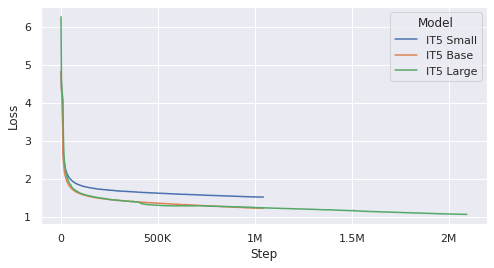

In [1]:
import pandas as pd

small = pd.read_csv("small.csv")
base = pd.read_csv("base.csv")
large = pd.read_csv("large.csv")

small["Model"] = "IT5 Small"
base["Model"] = "IT5 Base"
large["Model"] = "IT5 Large"

data = pd.concat([small, base, large], ignore_index=True)
data.rename(columns={"Value": "Loss"}, inplace=True)

import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(style="darkgrid")
sns.set(rc={"figure.figsize":(8, 4)})
g = sns.lineplot(data=data, x="Step", y="Loss", hue="Model")
g.set_xticklabels(['0','0', '500K','1M','1.5M','2M'])
plt.savefig("loss.pdf")